# HW 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## 1. RPCA

In [52]:
# (a) Formulate s semi-definite program for RPCA
m = 20
n = 20
r = 1
p = 0.1

# Construct Low-rank matrix L (rank-r)
A = np.random.randn(m, n)
U, _, V = np.linalg.svd(A)
L = U[:, :r] @ V[:, :r].T # L: (m, n)

# Construct sparse matrix E
probs = np.random.rand(m, n)
E = (probs>(1-p)).astype(float)

# Matrix M
M = L + E

In [53]:
# Formulate a semi-definite program for RPCA
def solve_rpca(M, m=20, n=20):
    # Optimization variables
    L = cp.Variable((m, n))
    S = cp.Variable((m, n))
    W1 = cp.Variable((m, n))
    W2 = cp.Variable((m, n))

    # Objective function, # cp.norm is not right
    lambda_param = 0.25  # Regularization parameter
    objective = cp.Minimize(0.5 * (cp.trace(W1) + cp.trace(W2)) +
                            lambda_param * cp.sum(cp.abs(S)))

    # Constraints
    constraints = [L + S >= M-1e-5, L + S <= M+1e-5,
                   cp.bmat([[W1, L], [L.T, W2]]) >> 0]

    # Problem
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    return result, L, S

result, L_rpca, S_rpca = solve_rpca(M)

# Output the result
print("The difference between sparse solution E and true S0:")
print(np.linalg.norm(S_rpca.value-E))
print("The difference between the low rank solution L and true L0:")
print(np.linalg.norm(L_rpca.value-L))

The difference between sparse solution E and true S0:
0.0006792049574384805
The difference between the low rank solution L and true L0:
0.0007042765272897545


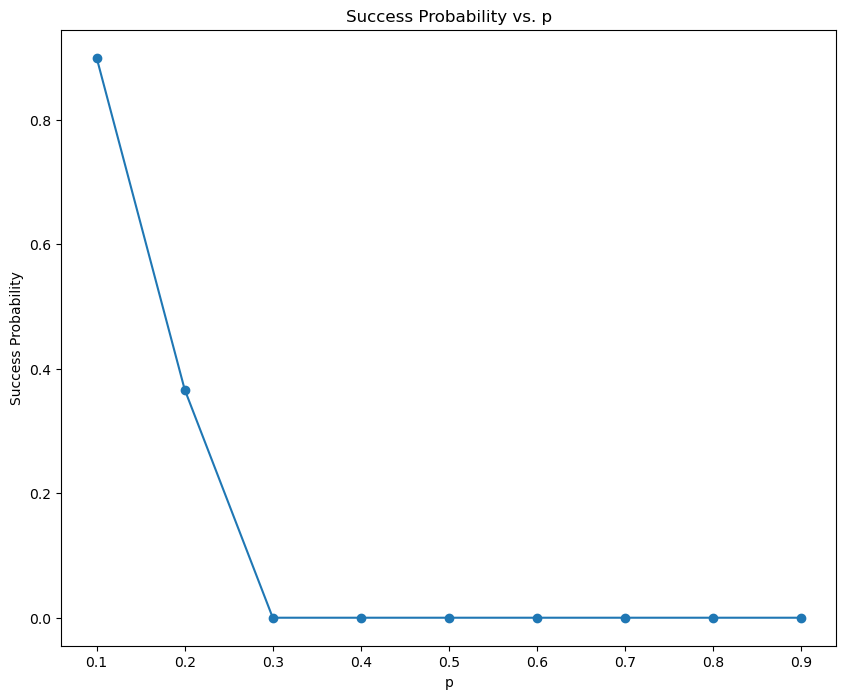

In [54]:
# (b) Explore the success probabilit with different p
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_trials = 30

# Prepare to store the success probabilities
success_prob = np.zeros(len(ps))

# Loop over each dimension n and sparsity k
for i, p in enumerate(ps):
    success_count = 0
    for _ in range(n_trials):
        # Construct Low-rank matrix L (rank-r)
        A = np.random.randn(m, n)
        U, _, V = np.linalg.svd(A)
        L = U[:, :r] @ V[:, :r].T  # L: (m, n)

        # Construct sparse matrix E
        probs = np.random.rand(m, n)
        E = (probs>(1-p)).astype(float)

        # Matrix M
        M = L + E

        result, L_rpca, S_rpca = solve_rpca(M)

        if np.linalg.norm(S_rpca.value-E) < 1e-3 and \
                np.linalg.norm(L_rpca.value-L) < 1e-3:
            success_count += 1

    # Store the success probability for this (n, k)
    success_prob[i] = success_count / n_trials

# Plotting the results
plt.figure(figsize=(10, 8))
plt.plot(ps, success_prob, marker='o')
plt.xlabel('p')
plt.ylabel('Success Probability')
plt.title('Success Probability vs. p')
plt.show()

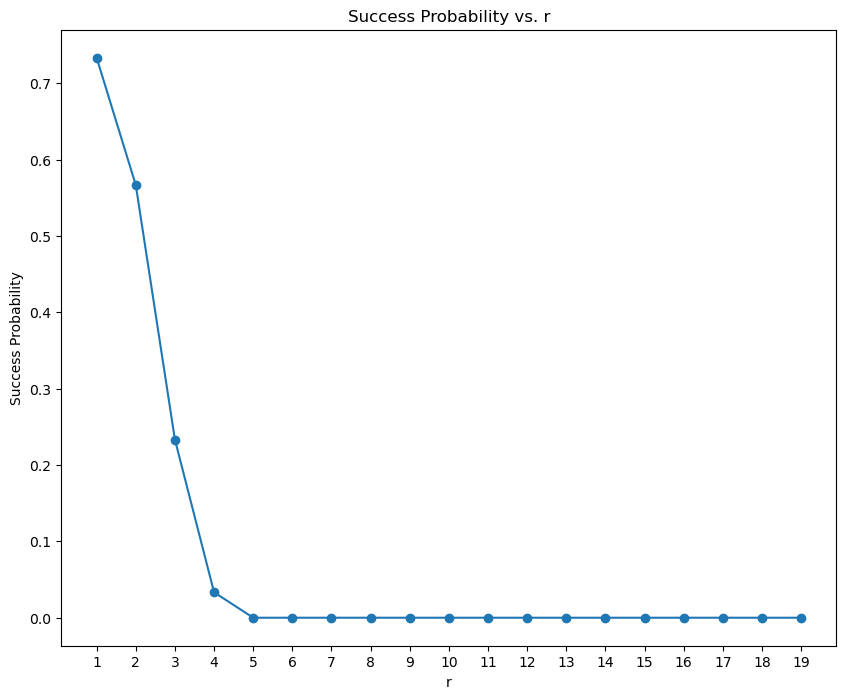

In [56]:
# (c) Explore the success probability with different r
rs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
n_trials = 30
p = 0.1  # fix p

# Prepare to store the success probabilities
success_prob = np.zeros(len(rs))

# Loop over each dimension n and sparsity k
for i, r in enumerate(rs):
    success_count = 0
    for _ in range(n_trials):
        # Construct Low-rank matrix L (rank-r)
        A = np.random.randn(m, n)
        U, _, V = np.linalg.svd(A)
        L = U[:, :r] @ V[:, :r].T

        # Construct sparse matrix E
        probs = np.random.rand(m, n)
        E = (probs>(1-p)).astype(float)

        # Matrix M
        M = L + E

        result, L_rpca, S_rpca = solve_rpca(M)

        if np.linalg.norm(S_rpca.value-E) < 1e-3 and \
                np.linalg.norm(L_rpca.value-L) < 1e-3:
            success_count += 1

    # Store the success probability for this (n, k)
    success_prob[i] = success_count / n_trials

# Plotting the results
plt.figure(figsize=(10, 8))
plt.plot(rs, success_prob, marker='o')
plt.xticks(rs)
plt.xlabel('r')
plt.ylabel('Success Probability')
plt.title('Success Probability vs. r')
plt.show()

## 2. SPCA

In [22]:
n = 2000
p = 10

X = np.zeros((p, n))  # X: (p, n)

V1 = np.random.normal(0, 290, size=(p, n))
V2 = np.random.normal(0, 300, size=(p, n))
V3 = -0.3*V1 + 0.925*V2 + np.random.normal(0, 1, size=(p, n))


X[0:4, :] = V1[0:4, :] + np.random.normal(0, 1, size=(p, n))[0:4, :]
X[4:8, :] = V2[4:8, :] + np.random.normal(0, 1, size=(p, n))[4:8, :]
X[8:10, :] = V3[8:10, :] + np.random.normal(0, 1, size=(p, n))[8:10, :]

print(X.shape)

(10, 2000)


In [23]:
#  (a) Compute the sample covariance matrix of X
sample_cov = np.cov(X)
print(sample_cov)

[[ 8.49729519e+04 -9.74772451e+02  2.70094632e+03  7.91051701e+02
  -6.96181796e+02  2.53528953e+02 -3.94447320e+02 -5.10305297e+02
   7.37597220e+02 -1.41115773e+03]
 [-9.74772451e+02  8.29867950e+04 -1.83854098e+03  2.47777696e+03
  -6.42392954e+02 -2.34666048e+02  2.73837040e+03  3.50791538e+03
  -2.45468779e+03 -1.12221704e+03]
 [ 2.70094632e+03 -1.83854098e+03  8.46790107e+04  3.67548014e+03
  -1.39787813e+03 -3.82057917e+02  1.57811783e+03 -2.09819767e+03
   1.19840565e+03  6.98091943e+01]
 [ 7.91051701e+02  2.47777696e+03  3.67548014e+03  8.08154068e+04
   2.85167055e+03  1.61636757e+03 -1.59516891e+03 -3.58893517e+01
   3.33988213e+03  2.80720192e+03]
 [-6.96181796e+02 -6.42392954e+02 -1.39787813e+03  2.85167055e+03
   9.07002237e+04 -1.23415816e+03 -2.20259741e+03 -1.07371193e+02
   2.88506928e+03  2.04405468e+03]
 [ 2.53528953e+02 -2.34666048e+02 -3.82057917e+02  1.61636757e+03
  -1.23415816e+03  8.81487900e+04  2.72400808e+02 -5.95064939e+02
   4.83961769e+02 -9.39908481e+02

In [24]:
# (b) Compute the top 4 principal components of X with SVD
U, S, V = np.linalg.svd(sample_cov)
top_4_pc = U[:, :4]
print(top_4_pc)

[[-0.07173793  0.13619751 -0.12604751 -0.33942168]
 [ 0.26794125 -0.02569516 -0.13410026  0.01374349]
 [-0.13967776  0.20689007 -0.28999233 -0.33008594]
 [-0.12710862 -0.15836044 -0.31592403 -0.3517287 ]
 [-0.22458933 -0.57320213 -0.59950213  0.2133357 ]
 [-0.02515669  0.15563908 -0.02426353 -0.67229432]
 [ 0.36400394  0.49925359 -0.57163324  0.25165766]
 [ 0.77976372 -0.42411677 -0.04735274 -0.26940864]
 [-0.27215125  0.01368056 -0.27618474 -0.04249254]
 [-0.14739344 -0.36167379  0.13018922 -0.12932228]]


In [25]:
# (c) Sparse PCA by SDP prlbem
def solve_spca(sample_cov, p=10, lambda_parameter=0.1):

    X = cp.Variable((p, p), symmetric=True)

    # Objective function
    objective = cp.Maximize(cp.trace(sample_cov @ X) -
                            lambda_parameter * cp.sum(cp.abs(X)))
    # Constraints
    constraints = [cp.trace(X) == 1, X >> 0]
    # Problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X

for lambda_parameter in [0.1, 0.2, 0.3, 0.4]:  #
    result = solve_spca(sample_cov, lambda_parameter=lambda_parameter)
    eigenvalues, eigenvectors = np.linalg.eig(result.value)

    print(f"First Sparse PCA (for lambda={lambda_parameter}):")
    print(eigenvectors[:, 0])
    print('First principal component by eigenvector decomposition:')
    print(U[:, 0], '\n')

First Sparse PCA (for lambda=0.1):
[-0.07172467  0.26794177 -0.1396735  -0.12709933 -0.22457864 -0.02513972
  0.36400221  0.77977419 -0.27214831 -0.14738447]
First principal component by eigenvector decomposition:
[-0.07173793  0.26794125 -0.13967776 -0.12710862 -0.22458933 -0.02515669
  0.36400394  0.77976372 -0.27215125 -0.14739344] 

First Sparse PCA (for lambda=0.2):
[ 0.07170996 -0.26793019  0.13965494  0.12707008  0.22454365  0.02512561
 -0.36397293 -0.77981772  0.27214491  0.1473595 ]
First principal component by eigenvector decomposition:
[-0.07173793  0.26794125 -0.13967776 -0.12710862 -0.22458933 -0.02515669
  0.36400394  0.77976372 -0.27215125 -0.14739344] 

First Sparse PCA (for lambda=0.3):
[-0.07169711  0.26792711 -0.13964452 -0.12704696 -0.22451926 -0.02511029
  0.36395788  0.77984978 -0.2721294  -0.14733704]
First principal component by eigenvector decomposition:
[-0.07173793  0.26794125 -0.13967776 -0.12710862 -0.22458933 -0.02515669
  0.36400394  0.77976372 -0.2721512

In [26]:
# (d) Remove first sparse PCA and compute the second sparse PCA
# Remove the first sparse PCA
sample_cov_2 = sample_cov - sample_cov@result.value

# Compute the second sparse PCA
result_2 = solve_spca(sample_cov_2, lambda_parameter=0)
egienvalues, eigenvectors = np.linalg.eig(result_2.value)

print("Second sparse PCA (for lambda=0):")
print(eigenvectors[:, 0])

print('Second principal component by eigenvector decomposition:')
print(U[:, 1])

Second sparse PCA (for lambda=0):
[ 0.13618688 -0.02565516  0.2068693  -0.15837946 -0.5732355   0.15563541
  0.49930795 -0.4240003   0.01363995 -0.3616959 ]
Second principal component by eigenvector decomposition:
[ 0.13619751 -0.02569516  0.20689007 -0.15836044 -0.57320213  0.15563908
  0.49925359 -0.42411677  0.01368056 -0.36167379]


In [27]:
# (e) Compute the third and fourth sparse PCA
# Remove the second sparse PCA
sample_cov_3 = sample_cov_2 - sample_cov@result_2.value

# Compute the third sparse PCA
result_3 = solve_spca(sample_cov_3, lambda_parameter=0)
egienvalues, eigenvectors = np.linalg.eig(result_3.value)

print("Third sparse PCA (for lambda=0):")
print(eigenvectors[:, 0])
print('Third principal component by eigenvector decomposition:')
print(U[:, 2], '\n')

# Remove the third sparse PCA
sample_cov_4 = sample_cov_3 - sample_cov@result_3.value

# Compute the fourth sparse PCA
result_4 = solve_spca(sample_cov_4, lambda_parameter=0)
egienvalues, eigenvectors = np.linalg.eig(result_4.value)

print("Fourth sparse PCA (for lambda=0):")
print(eigenvectors[:, 0])
print('Fourth principal component by eigenvector decomposition:')
print(U[:, 3])

Third sparse PCA (for lambda=0):
[ 0.12605101  0.13408042  0.29000042  0.31593149  0.59952013  0.02426385
  0.5716077   0.04729435  0.2762043  -0.13017901]
Third principal component by eigenvector decomposition:
[-0.12604751 -0.13410026 -0.28999233 -0.31592403 -0.59950213 -0.02426353
 -0.57163324 -0.04735274 -0.27618474  0.13018922] 

Fourth sparse PCA (for lambda=0):
[ 0.33943085 -0.0137834   0.33010487  0.35174815 -0.21329758  0.67230296
 -0.2517098   0.26928944  0.04253487  0.12934356]
Fourth principal component by eigenvector decomposition:
[-0.33942168  0.01374349 -0.33008594 -0.3517287   0.2133357  -0.67229432
  0.25165766 -0.26940864 -0.04249254 -0.12932228]


The reuslt shows that the sparse PCA basically obtain same principal components as eigenvector decomposition. (Ecept for the sign of the eigenvectors, the direction of some vector can be opposite.)